In [289]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [290]:
df=pd.read_csv('training.csv')
#make all strings
df['article_words']=df['article_words'].apply(str)

#get rid of commas/punctuation
punctuation_signs = list("?:!.,;")
df['article_words_parse_1'] = df['article_words']

for punct_sign in punctuation_signs:
    df['article_words_parse_1'] = df['article_words_parse_1'].str.replace(punct_sign, ' ')
    
#all lower case
df['article_words_parse_2'] = df['article_words_parse_1'].str.lower()

#NO STEMMING NO LEMMISATION, NO STOP WORDS

#Category Numbers
category_codes = {
    'ARTS CULTURE ENTERTAINMENT': 0,
    'BIOGRAPHIES PERSONALITIES PEOPLE': 1,
    'DEFENCE': 2,
    'DOMESTIC MARKETS': 3,
    'FOREX MARKETS': 4,
    'HEALTH': 5,
    'IRRELEVANT': 6,
    'MONEY MARKETS': 7,
    'SCIENCE AND TECHNOLOGY': 8,
    'SHARE LISTINGS': 9,
    'SPORTS': 10
}

# Category mapping
df['Category_Code'] = df['topic']
df = df.replace({'Category_Code':category_codes})


df = df.drop(["article_words", "article_words_parse_1"], axis=1)


print(df)

      article_number          topic  \
0                  1  FOREX MARKETS   
1                  2  MONEY MARKETS   
2                  3         SPORTS   
3                  4  FOREX MARKETS   
4                  5     IRRELEVANT   
...              ...            ...   
9495            9496        DEFENCE   
9496            9497     IRRELEVANT   
9497            9498  FOREX MARKETS   
9498            9499     IRRELEVANT   
9499            9500  FOREX MARKETS   

                                  article_words_parse_2  Category_Code  
0     open absent cent cent cent stock inflow rate k...              4  
1     morn stead end end day day day patch patch pat...              7  
2     socc socc world world recent law fifa fifa fif...             10  
3     open forint forint forint forint cent cent ste...              4  
4     morn complet weekend minut minut minut arrow d...              6  
...                                                 ...            ...  
9495  cloud provid h

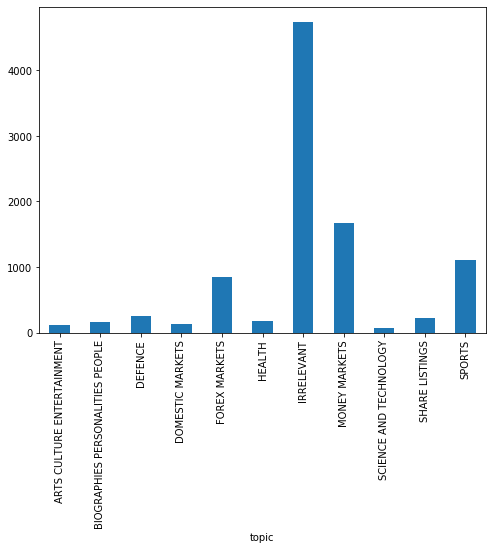

In [291]:
#Data Analysis
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('topic').article_words_parse_2.count().plot.bar(ylim=0)
plt.show()

In [302]:
#Try to get rid of Irrelevant

# 0=Irrelevant, 1=Relevant
new_code = {
    'ARTS CULTURE ENTERTAINMENT': 1,
    'BIOGRAPHIES PERSONALITIES PEOPLE': 1,
    'DEFENCE': 1,
    'DOMESTIC MARKETS': 1,
    'FOREX MARKETS': 1,
    'HEALTH': 1,
    'IRRELEVANT': 0,
    'MONEY MARKETS': 1,
    'SCIENCE AND TECHNOLOGY': 1,
    'SHARE LISTINGS': 1,
    'SPORTS': 1
}

new_name = {
    'ARTS CULTURE ENTERTAINMENT': 'RELEVANT',
    'BIOGRAPHIES PERSONALITIES PEOPLE': 'RELEVANT',
    'DEFENCE': 'RELEVANT',
    'DOMESTIC MARKETS': 'RELEVANT',
    'FOREX MARKETS': 'RELEVANT',
    'HEALTH': 'RELEVANT',
    'IRRELEVANT': 'IRRELEVANT1',
    'MONEY MARKETS': 'RELEVANT',
    'SCIENCE AND TECHNOLOGY': 'RELEVANT',
    'SHARE LISTINGS': 'RELEVANT',
    'SPORTS': 'RELEVANT'
}

# Category mapping
df['binary_code'] = df['topic']
df['binary_topic']=df['topic']
df = df.replace({'binary_code':new_code})
df = df.replace({'binary_topic':new_name})

X_train, X_test, y_train, y_test, topic_train, topic_test, category_train, category_test, article_train, article_test= train_test_split(df['article_words_parse_2'], 
                                                    df['binary_code'],df['topic'], df['Category_Code'], df['article_number'],
                                                    random_state=8)


print(X_test)
print(y_test)

5525    fitch fitch artem correct correct group munici...
8594    flow vanhoos research research supercold nasa ...
2123    flow flow flow purchas purchas purchas purchas...
7647    hear investig investig cover cover seek hope c...
23      regist cent ensur half half half half half sto...
                              ...                        
1955    stead stead stead missor gilt top top moderat ...
6209    option cent derivat daily daily cross local ba...
3247    jerry issu heard jasinowsk jasinowsk assoc quo...
7518    figur rate fall issu aug labor econom norway n...
7810    research research research cent fujitsu fujits...
Name: article_words_parse_2, Length: 2375, dtype: object
5525    0
8594    1
2123    1
7647    1
23      0
       ..
1955    0
6209    1
3247    1
7518    0
7810    0
Name: binary_code, Length: 2375, dtype: int64
5525    5526
8594    8595
2123    2124
7647    7648
23        24
        ... 
1955    1956
6209    6210
3247    3248
7518    7519
7810    7811
Name: 

In [295]:
#TFIDF
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 6000

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)


(7125, 6000)
(2375, 6000)


The training accuracy is: 
0.8526315789473684
The test accuracy is: 
0.8425263157894737
Classification report
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1191
           1       0.87      0.81      0.84      1184

    accuracy                           0.84      2375
   macro avg       0.84      0.84      0.84      2375
weighted avg       0.84      0.84      0.84      2375



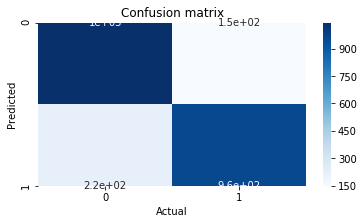

In [296]:
from sklearn.naive_bayes import MultinomialNB
#MNB
mnbc = MultinomialNB()

#clf = mnbc.fit(features_train, labels_train)
mnbc.fit(features_train, labels_train)
mnbc_pred = mnbc.predict(features_test)

print("The training accuracy is: ")
print(accuracy_score(labels_train, mnbc.predict(features_train)))

print("The test accuracy is: ")
print(accuracy_score(labels_test, mnbc_pred))

print("Classification report")
print(classification_report(labels_test,mnbc_pred))

aux_df = df[['binary_topic', 'binary_code']].drop_duplicates().sort_values('binary_code')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(6,3))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['binary_code'].values, 
            yticklabels=aux_df['binary_code'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [304]:
#https://towardsdatascience.com/naive-bayes-document-classification-in-python-e33ff50f937e
testing_predictions = []
for i in range(len(X_test)):
    if mnbc_pred[i] == 1:
        testing_predictions.append('RELEVANT')
    else:
        testing_predictions.append('IRRELEVANT')
check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'words':list(X_test), 'topic':list(topic_test), 'category':list(category_test), 'article':list(article_test)})
check_df.actual_label.replace(to_replace=0, value='IRRELEVANT', inplace=True)
check_df.actual_label.replace(to_replace=1, value='RELEVANT', inplace=True)

print(check_df)

check_df.category.unique()



     actual_label  prediction  \
0      IRRELEVANT  IRRELEVANT   
1        RELEVANT  IRRELEVANT   
2        RELEVANT  IRRELEVANT   
3        RELEVANT  IRRELEVANT   
4      IRRELEVANT  IRRELEVANT   
...           ...         ...   
2370   IRRELEVANT  IRRELEVANT   
2371     RELEVANT    RELEVANT   
2372     RELEVANT    RELEVANT   
2373   IRRELEVANT  IRRELEVANT   
2374   IRRELEVANT  IRRELEVANT   

                                                  words  \
0     fitch fitch artem correct correct group munici...   
1     flow vanhoos research research supercold nasa ...   
2     flow flow flow purchas purchas purchas purchas...   
3     hear investig investig cover cover seek hope c...   
4     regist cent ensur half half half half half sto...   
...                                                 ...   
2370  stead stead stead missor gilt top top moderat ...   
2371  option cent derivat daily daily cross local ba...   
2372  jerry issu heard jasinowsk jasinowsk assoc quo...   
2373  figur r

array([ 6,  8,  7,  2,  4,  9, 10,  1,  3,  5,  0], dtype=int64)

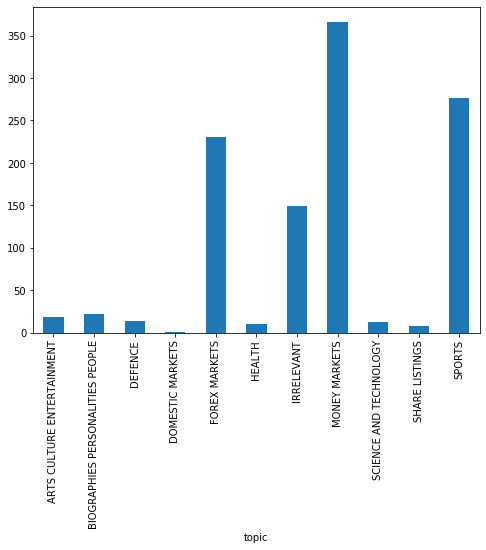

0        4
1        7
2       10
3        4
5        9
        ..
9491     1
9492     7
9495     2
9497     4
9499     4
Name: Category_Code, Length: 4766, dtype: int64
9       4
10      6
15      7
20      7
22      6
       ..
2363    4
2366    7
2367    6
2371    7
2372    4
Name: category, Length: 1108, dtype: int64
(4766, 6000)
(1108, 6000)


In [308]:
#THIS IS NOW OUR NEW TEST SET WITH NO IRRELEVANT FILES
check_df = check_df[check_df.prediction != 'IRRELEVANT']


#Data Analysis
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
check_df.groupby('topic').words.count().plot.bar(ylim=0)
plt.show()

#print(check_df) #1108

#get the original dataset and remove all irrelevant articles
new_df=df
new_df = new_df[new_df.topic != 'IRRELEVANT']
#print(new_df) #4766

X_train=new_df['article_words_parse_2']
X_test=check_df['words']
y_train=new_df['Category_Code']
y_test=check_df['category']
article_test=check_df['article']

print(y_train)
print(y_test)

features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)


In [309]:
#MNB
clf = MultinomialNB()
clf

clf.fit(features_train, labels_train)
clf_pred = clf.predict(features_test)

print("The training accuracy is: ")
print(accuracy_score(labels_train, clf.predict(features_train)))

print("The test accuracy is: ")
print(accuracy_score(labels_test, clf_pred))

print("Classification report")
print(classification_report(labels_test,clf_pred))


The training accuracy is: 
0.7956357532522031
The test accuracy is: 
0.6787003610108303
Classification report
              precision    recall  f1-score   support

           0       1.00      0.39      0.56        18
           1       0.62      0.73      0.67        22
           2       0.46      0.93      0.62        14
           3       1.00      1.00      1.00         1
           4       0.63      0.42      0.50       231
           5       0.46      0.60      0.52        10
           6       0.00      0.00      0.00       149
           7       0.58      0.89      0.70       366
           8       1.00      0.46      0.63        13
           9       1.00      0.75      0.86         8
          10       0.89      1.00      0.94       276

    accuracy                           0.68      1108
   macro avg       0.69      0.65      0.64      1108
weighted avg       0.60      0.68      0.62      1108



C:\Users\Stephen Sung\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


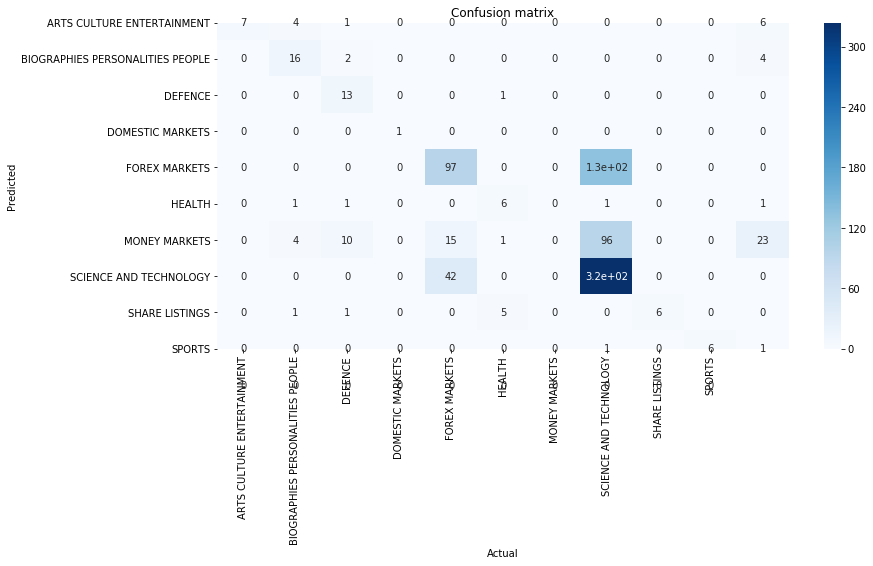

In [300]:
aux_df2 = new_df[['topic', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix2 = confusion_matrix(labels_test, clf_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix2, 
            annot=True,
            xticklabels=aux_df2['topic'].values, 
            yticklabels=aux_df2['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()


In [310]:
testing_predictions1 = []
for i in range(len(X_test)):
    if clf_pred[i] == 0:
        testing_predictions1.append('ARTS CULTURE ENTERTAINMENT')
    elif clf_pred[i] == 1:
        testing_predictions1.append('BIOGRAPHIES PERSONALITIES PEOPLE')
    elif clf_pred[i] == 2:
        testing_predictions1.append('DEFENCE')
    elif clf_pred[i] == 3:
        testing_predictions1.append('DOMESTIC MARKETS')
    elif clf_pred[i] == 4:
        testing_predictions1.append('FOREX MARKETS')
    elif clf_pred[i] == 5:
        testing_predictions1.append('HEALTH')
    elif clf_pred[i] == 6:
        testing_predictions1.append('IRRELEVANT')
    elif clf_pred[i] == 7:
        testing_predictions1.append('MONEY MARKETS')
    elif clf_pred[i] == 8:
        testing_predictions1.append('SCIENCE AND TECHNOLOGY')
    elif clf_pred[i] == 9:
        testing_predictions1.append('SHARE LISTINGS')
    elif clf_pred[i] == 10:
        testing_predictions1.append('SPORTS')
    else:
        testing_predictions1.append('ERROR')
check_df1 = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions1, 'article': list(article_test)})
check_df1.actual_label.replace(to_replace=0, value='ARTS CULTURE ENTERTAINMENT', inplace=True)
check_df1.actual_label.replace(to_replace=1, value='BIOGRAPHIES PERSONALITIES PEOPLE', inplace=True)
check_df1.actual_label.replace(to_replace=2, value='DEFENCE', inplace=True)
check_df1.actual_label.replace(to_replace=3, value='DOMESTIC MARKETS', inplace=True)
check_df1.actual_label.replace(to_replace=4, value='FOREX MARKETS', inplace=True)
check_df1.actual_label.replace(to_replace=5, value='HEALTH', inplace=True)
check_df1.actual_label.replace(to_replace=6, value='IRRELEVANT', inplace=True)
check_df1.actual_label.replace(to_replace=7, value='MONEY MARKETS', inplace=True)
check_df1.actual_label.replace(to_replace=8, value='SCIENCE AND TECHNOLOGY', inplace=True)
check_df1.actual_label.replace(to_replace=9, value='SHARE LISTINGS', inplace=True)
check_df1.actual_label.replace(to_replace=10, value='SPORTS', inplace=True)

print(check_df1)

       actual_label                        prediction  article
0     FOREX MARKETS                     FOREX MARKETS     4348
1        IRRELEVANT  BIOGRAPHIES PERSONALITIES PEOPLE     6929
2     MONEY MARKETS                     FOREX MARKETS     5331
3     MONEY MARKETS                     MONEY MARKETS     3755
4        IRRELEVANT                     MONEY MARKETS     2853
...             ...                               ...      ...
1103  FOREX MARKETS                     MONEY MARKETS     3545
1104  MONEY MARKETS                     MONEY MARKETS      197
1105     IRRELEVANT                           DEFENCE      721
1106  MONEY MARKETS                     MONEY MARKETS     6210
1107  FOREX MARKETS                     FOREX MARKETS     3248

[1108 rows x 3 columns]


In [278]:
check_df1[check_df1.prediction == 'ARTS CULTURE ENTERTAINMENT'].shape[0]

7

In [279]:
check_df1[check_df1.prediction == 'BIOGRAPHIES PERSONALITIES PEOPLE'].shape[0]

26

In [280]:
check_df1[check_df1.prediction == 'DEFENCE'].shape[0]

28

In [281]:
check_df1[check_df1.prediction == 'DOMESTIC MARKETS'].shape[0]

1

In [282]:
check_df1[check_df1.prediction == 'FOREX MARKETS'].shape[0]

154

In [283]:
check_df1[check_df1.prediction == 'HEALTH'].shape[0]

13

In [284]:
check_df1[check_df1.prediction == 'IRRELEVANT'].shape[0]

0

In [285]:
check_df1[check_df1.prediction == 'MONEY MARKETS'].shape[0]

556

In [286]:
check_df1[check_df1.prediction == 'SCIENCE AND TECHNOLOGY'].shape[0]

6

In [287]:
check_df1[check_df1.prediction == 'SHARE LISTINGS'].shape[0]

6

In [288]:
check_df1[check_df1.prediction == 'SPORTS'].shape[0]

311